# Assignment 1

**Content-Based Image Retrieval**


Similar Image Retrieval (aka Content-Based Image Retrieval or CBIR) is any search that involves images.
Nowadays the "Search by photo" approach is being used more and more actively, in particular, in e-commerce services (AliExpress, Wildberries, etc.). "Keyword search" (with an understanding of the content of images) has long settled in the search engines Google, Yandex, etc.,

**How does it work ?**


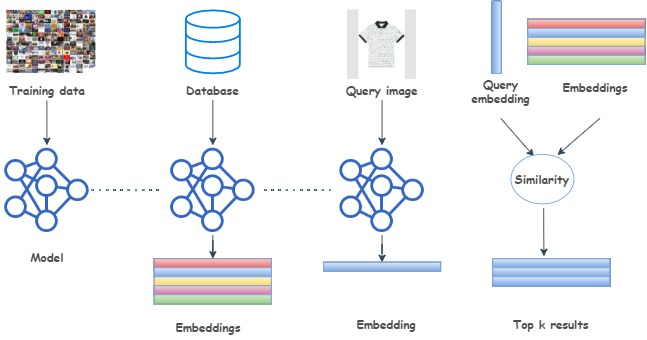


As you can see the pipeline seems easy. First we need a dataset, in this assignment we will be using a large scale benchmark dataset called the Inshop dataset (use the one provided in the link ;) ). The dataset contains training set and testing set. The testing set is divided into two parts query images and gallery images. The query set basically contains images that we will be searching for in the gallery set.


 
**Steps:**
1. Download the dataset 
2. Read the dataset and put it in an appropriate format 
3. Choose a model (you can use pretrained ;) ) and train it
4. Wisely choose a loss function in deep metric learning there are many such as : Contrastive loss, Triplet loss, multi similarity loss, XBM .... Implement one of them. 
5. Measure the scores using the recall metric
6. Report results ( recall values , loss) using tensorboard or Comet or any tool you are comfortable with.  


In [1]:
import os
import time
import random
import numpy as np

import torch.optim as optim
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

from IPython.display import clear_output
from PIL import Image
from torch.utils.data import DataLoader, Subset, Dataset
from torch.utils.data import random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, CenterCrop

## Read data

In [2]:
some_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.ToTensor()
])

data_dir = '/kaggle/input/pmldl1/Inshop-data'
train_ds1 = ImageFolder(data_dir+'/train_data', transform=some_transforms)
gallery_ds = ImageFolder(data_dir+'/gallery_data/gallery', transform=some_transforms)
query_ds = ImageFolder(data_dir+'/query_data/query', transform=some_transforms)

In [3]:
class PairedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = random.choice(self.dataset.imgs)
        im = Image.open(image)
        pair = None
        sign = ''
        r = np.random.uniform(0, 1)
        if r > 0.5:
            sign = 'positive'
        else:
            sign = 'negative'
            
        if sign == 'positive':
            match = False
            while not match:
                i, l = random.choice(self.dataset.imgs)
                if label == l:
                    match = True
                    pair = i
            return self.transform(im), self.transform(Image.open(pair)), 1
        elif sign == 'negative':
            match = False
            while not match:
                i, l = random.choice(self.dataset.imgs)
                if label != l:
                    match = True
                    pair = i
            return self.transform(im), self.transform(Image.open(pair)), 0

In [4]:
train_ds = PairedDataset(train_ds1, transforms.ToTensor())

In [5]:
batch_size=64

In [6]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
gallery_dl = DataLoader(gallery_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
query_dl = DataLoader(query_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Model & loss function

In [7]:
out_num = 10
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, out_num)
clear_output()

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
gallery_dl = DeviceDataLoader(gallery_dl, device)
query_dl = DeviceDataLoader(query_dl, device)
to_device(model, device);

In [11]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [12]:
loss_func = ContrastiveLoss()

## Train Test

In [13]:
from annoy import AnnoyIndex

f = out_num
t = AnnoyIndex(f, 'angular')

In [14]:
def train(model, train_loader, optimizer):
    model.train()
    c = 0
    for batch in train_loader:
        
        if c % 20 == 0:
            print(c)
        c+=1
        
        optimizer.zero_grad()
        image1, image2, label = batch
        out1 = model(image1)
        out2 = model(image2)
        loss = loss_func(out1, out2, label)
        loss.backward()
        optimizer.step()


def test(model, gallery_loader, query_loader):
    
    gallery_embeddings = []
    query_embeddings = []
    
    gallery_labels = []
    query_labels = []
    
    counter = 0
    for images, labels in gallery_loader:
        outs = model(images)
        
        for out in outs:
            t.add_item(counter, out)
            counter += 1
        
        gallery_embeddings.append(outs)
        gallery_labels.append(labels)
        
    for images, labels in query_loader:
        
        outs = model(images)
        query_embeddings.append(outs)
        query_labels.append(labels)
        
    gallery_embeddings = torch.cat(gallery_embeddings, 0)
    query_embeddings = torch.cat(query_embeddings, 0)
    
    gallery_labels = torch.cat(gallery_labels, 0)
    query_labels = torch.cat(query_labels, 0)
    
    recall = RecallMetric([gallery_embeddings, query_embeddings], [gallery_labels, query_labels])
    return recall.recall_at_k(1), recall.recall_at_k(5), recall.recall_at_k(10)

### Recall metric

In [15]:
class RecallMetric(object):
    def __init__(self, feats, labels):

        """
         This function calculates the recall metric 

         feats = [gallery_embeddings, query_embeddings]
         labels = [gallery_labels, query_labels]
        """
        self.is_equal_query = False
        self.gallery_feats, self.query_feats = feats
        self.gallery_labels, self.query_labels = labels
        self.sim_mat = torch.matmul(self.query_feats, torch.transpose(self.gallery_feats, 0, 1))

    def recall_at_k(self, k=1):
        m = len(self.sim_mat)
        match_counter = 0
        for i in range(m):
            pos_sim = self.sim_mat[i][self.gallery_labels == self.query_labels[i]]
            neg_sim = self.sim_mat[i][self.gallery_labels != self.query_labels[i]]
            thresh = pytoch.sort(pos_sim)[-2] if self.is_equal_query else torch.max(pos_sim)
            if torch.sum(neg_sim > thresh) < k:
                match_counter += 1
        return float(match_counter) / m

In [16]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)
num_epochs = 2

In [17]:
for epoch in range(1, num_epochs + 1):
    
    print("Epoch {}".format(epoch))
    print("training..")
    train(model, train_dl, optimizer)
    print("testing..")
    recall_at_1, recall_at_5, recall_at_10 = test(model, gallery_dl, query_dl)
    print("Recall@1 : {:.4f} Recall@5 : {:.4f} Recall@10 : {:.4f}".format(recall_at_1,recall_at_5,recall_at_10))



Epoch 1
training..
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
testing..
Recall@1 : 0.0037 Recall@5 : 0.0165 Recall@10 : 0.0263
Epoch 2
training..
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
testing..
Recall@1 : 0.0032 Recall@5 : 0.0200 Recall@10 : 0.0358


## Visualization 


Use a retrieval technique like KNN, annoy, KD-tree (you are free to choose). 

Plot 3 query images with their respective top 5 results 



In [18]:
t.build(60)

True

orig


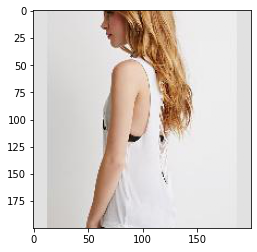

res


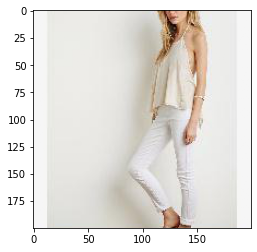

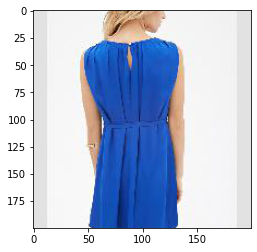

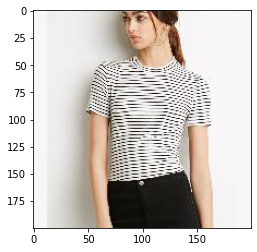

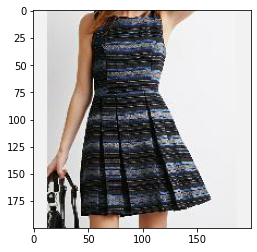

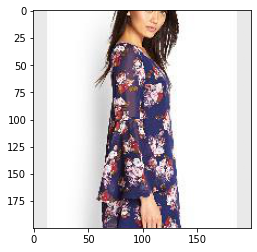

orig


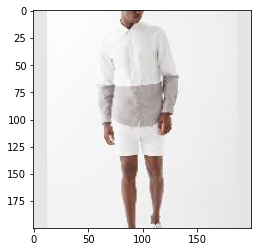

res


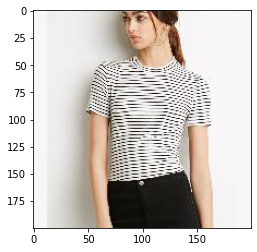

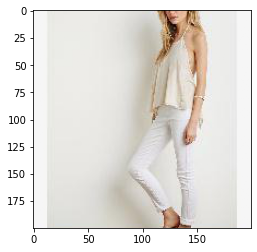

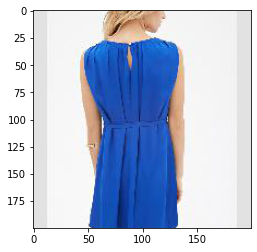

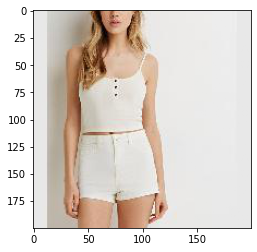

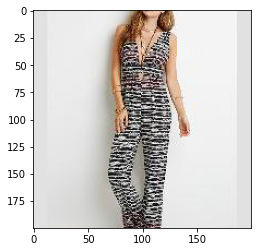

orig


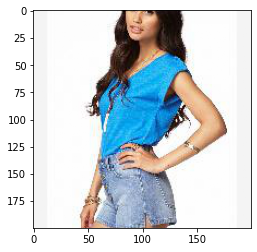

res


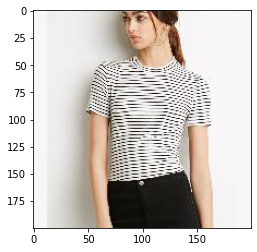

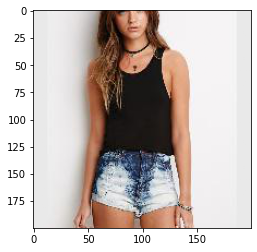

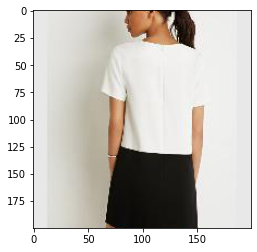

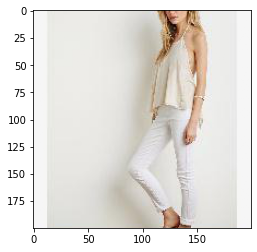

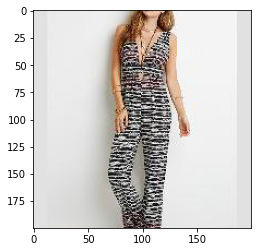

In [19]:
queries = [query_ds[20], query_ds[300], query_ds[4000]]
for query in queries:
    print("orig")
    plt.imshow(query[0].permute(1, 2, 0))
    plt.show()
    i = query[0].unsqueeze(0).cuda()
    embedding = model(i)
    results = t.get_nns_by_vector(embedding[0], 5)
    print("res")
    for result in results:
        plt.imshow(gallery_ds[result][0].permute(1, 2, 0))
        plt.show()
    print("=======================================")